In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='C:/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
ELEC_FILE='electricity.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed

In [4]:
elec_df = read_zip_to_panda(ZIP_PATH,ELEC_FILE)
elec_df = fix_date_type(elec_df)
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB


In [5]:
elec_df = elec_df['Eagle_assembly_Portia'] #['1-1-2016':'12-31-2016']
building = elec_df
building = building.replace( 0,  4)
elec_df.describe()

count    17544.000000
mean       129.481377
std         55.910261
min          0.000000
25%         85.700000
50%        113.868550
75%        163.129375
max        354.718700
Name: Eagle_assembly_Portia, dtype: float64

<AxesSubplot:xlabel='timestamp'>

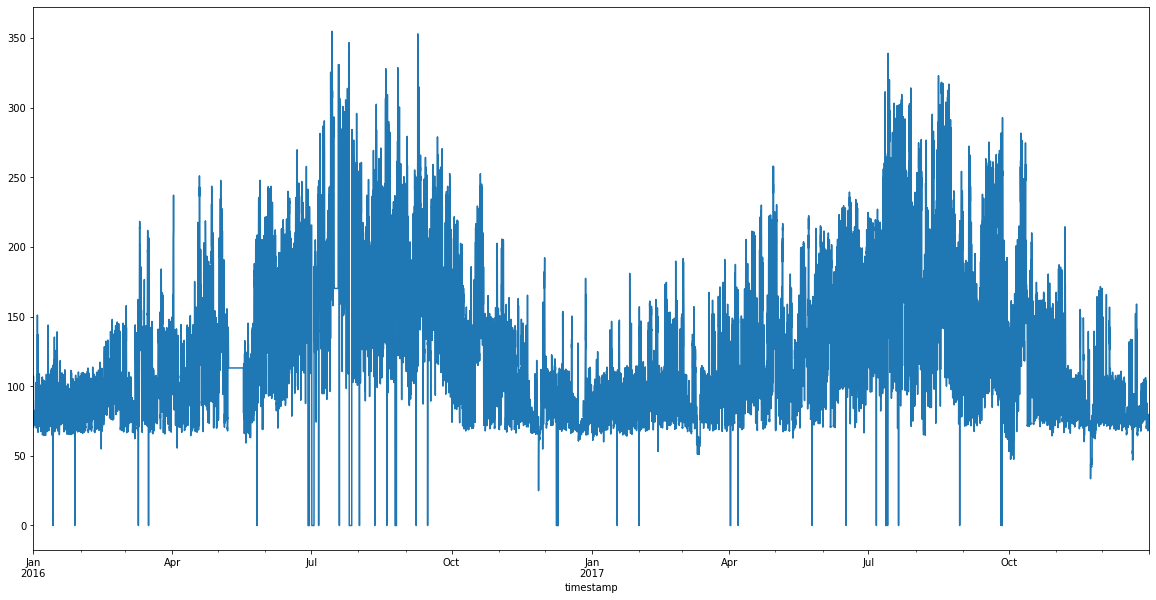

In [6]:
elec_df.plot(figsize=(20,10))

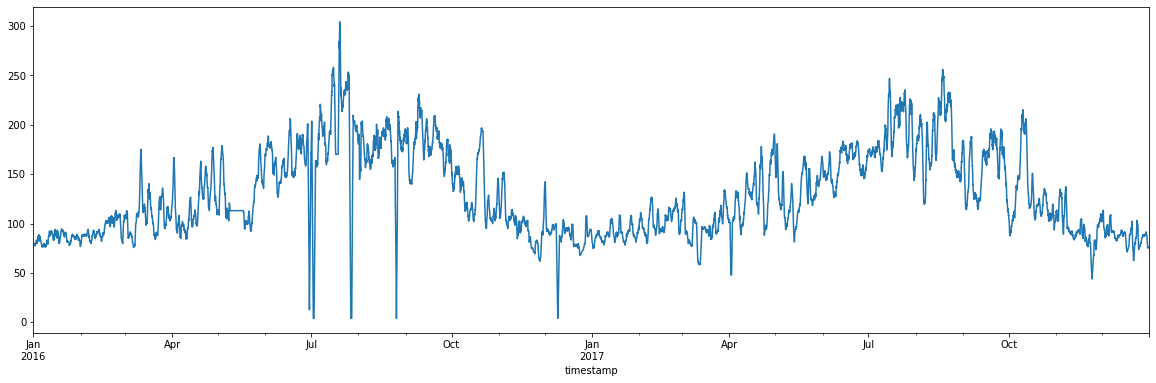

In [7]:
smooth=building.rolling(window=24).mean()
smooth.plot(figsize=(20,6))
plt.show()


## Stationarity Check

In [8]:
#Checking the Stationarity: series that has a constant mean

#Perform Building Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n the test statistic is less than critical value, reject the null hypothesis')
dftest = adfuller(building, autolag = 'AIC') #AIC gives the information about time series 

dfoutput= pd.Series (dftest[0:4], index= ['Test Statistic','p-value: \n p-value is smaller than 0.05','#lags used', 'Number of Observations Used'])
for key, value in dftest [4].items ():
    dfoutput ['Critical Value (%s)' %key] = value

print (dfoutput)

Results of Dickey-Fuller Test: 
 the test statistic is less than critical value, reject the null hypothesis
Test Statistic                             -6.632415e+00
p-value: \n p-value is smaller than 0.05    5.671271e-09
#lags used                                  4.400000e+01
Number of Observations Used                 1.749900e+04
Critical Value (1%)                        -3.430724e+00
Critical Value (5%)                        -2.861705e+00
Critical Value (10%)                       -2.566858e+00
dtype: float64


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

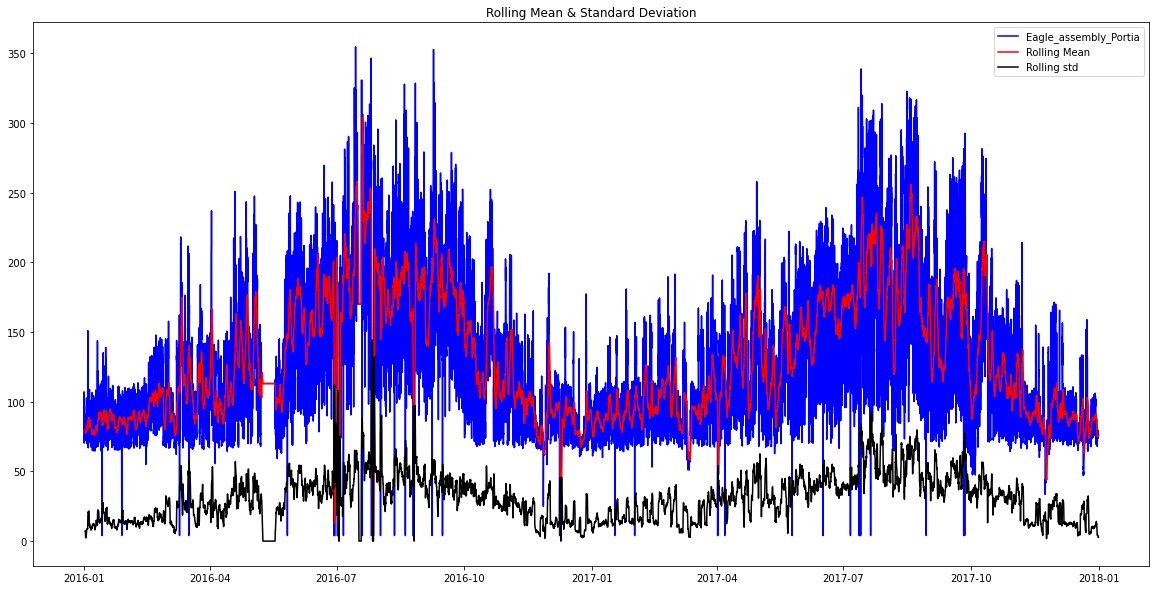

In [9]:

#Determine the rolling statistic
rolmean = building.rolling(window = 24).mean()
rolstd = building.rolling(window = 24).std()

#Checking the Stationarity
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot (building, color = 'blue',label = 'Eagle_assembly_Portia')
mean = plt.plot (rolmean, color = 'red',label = 'Rolling Mean')
std = plt.plot (rolstd, color = 'black',label = 'Rolling std')
plt.legend (loc ='best')
plt.title ('Rolling Mean & Standard Deviation')
#plt.show (block = False)


In [10]:
#Log transformation
building = building.replace( 0,  4)
building_logscale = np.log(building)


<AxesSubplot:xlabel='timestamp'>

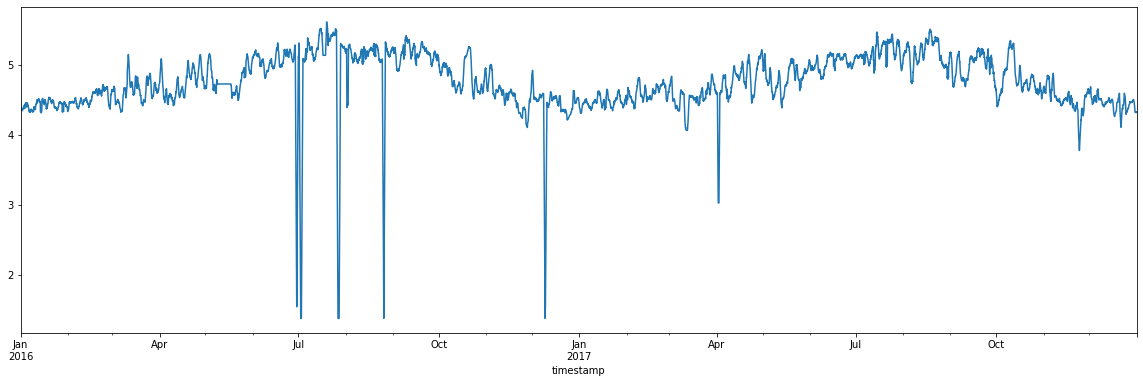

In [11]:
moving_avg =building_logscale.rolling(window = 24).mean()
moving_avg.plot(figsize=(20,6))

The result:
[89.81 89.82 81.47 ... 76.13 76.26 76.76]
[nan nan nan ... nan nan nan]
[ 15.11  -7.28 -15.1  ...  12.26  20.68  16.08]
[nan nan nan ... nan nan nan]


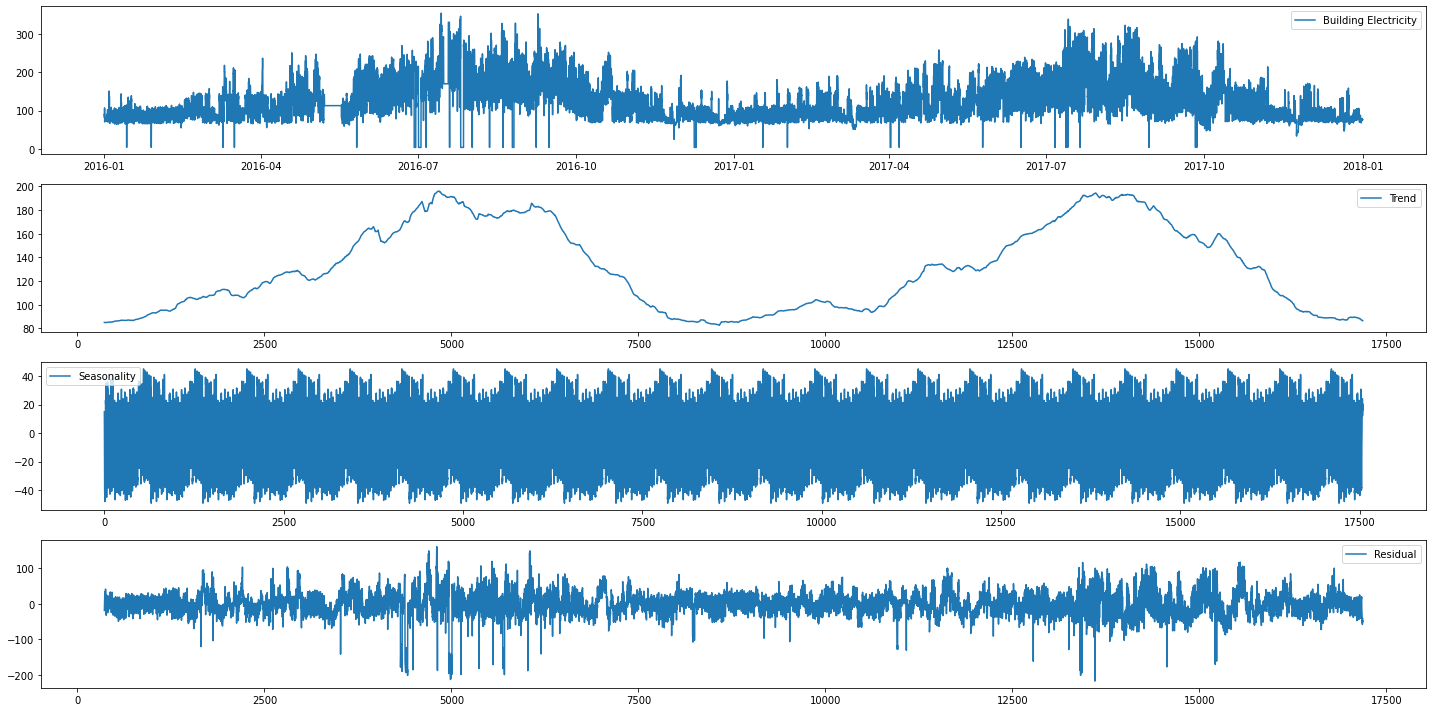

In [12]:
#Automatic Time Series Decomposition

decomposition = seasonal_decompose (building.values,period = 24*30, model = 'additive') 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (20,10))
fig = plt.figure(1)


plt.subplot (411)
plt.plot (building, label = 'Building Electricity')
plt.legend(loc ='best')

plt.subplot (412)
plt.plot (trend,label = 'Trend')
plt.legend(loc ='best')

plt.subplot (413)
plt.plot (seasonal, label = 'Seasonality')
plt.legend(loc ='best')

plt.subplot (414)
plt.plot (residual, label = 'Residual')
plt.legend(loc ='best')

plt.tight_layout()

print('The result:')
print(decomposition.observed)
print(decomposition.trend)
print(decomposition.seasonal)
print(decomposition.resid)


## Determine the order of AR, I and MA component 
Using AFC autocorreclation plot and PACF partial autocorrelatioin plot

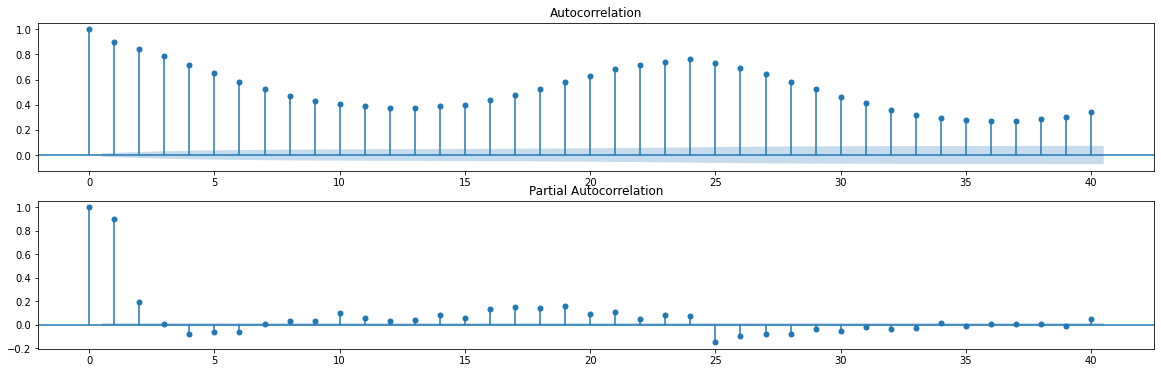

In [13]:
fig = plt.figure(figsize = (20,6))
building_acf = fig.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf (building.dropna(),lags = 40, ax = building_acf )
building_pacf = fig.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf (building.dropna(),lags = 40, ax = building_pacf )

Using auto_arima function

In [14]:

#adf_fit = auto_arima(building, trace = True)
#adf_fit.summary()

## ARIMA


AR = p = period for autoregressive model (regression the past lag value, PACF method),
<br>
Integrated = d = order of autoregression (differenced value from present and previous to eliminate the effects of seasonality; removing the trend and seasonality to make it stationary)
<br>
MA = q = periods in moving average (present value is not only depended on the past value but the error lag value as well, use the ACF method)

In [25]:
#Build ARIMA model

model = ARIMA(building, order = (3,1,4)) #number of order taken from the acf and pcf graph
model = model.fit()


In [26]:
pd.DataFrame (building)

,Eagle_assembly_Portia
timestamp,
2016-01-01 00:00:00,89.8141
2016-01-01 01:00:00,89.8240
2016-01-01 02:00:00,81.4715
2016-01-01 03:00:00,107.1195
2016-01-01 04:00:00,70.3711
...,...
2017-12-31 19:00:00,76.2361
2017-12-31 20:00:00,77.1076
2017-12-31 21:00:00,76.1266


In [27]:
pred = model.predict(start = len (building), end = len(building)+24*7, typ = 'levels'). rename ('ARIMA predictions')
pd.DataFrame(pred)


,ARIMA predictions
2018-01-01 00:00:00,76.230317
2018-01-01 01:00:00,76.073812
2018-01-01 02:00:00,75.473401
2018-01-01 03:00:00,75.386219
2018-01-01 04:00:00,75.055535
...,...
2018-01-07 20:00:00,75.818059
2018-01-07 21:00:00,75.834513
2018-01-07 22:00:00,75.815268
2018-01-07 23:00:00,75.834405


<AxesSubplot:>

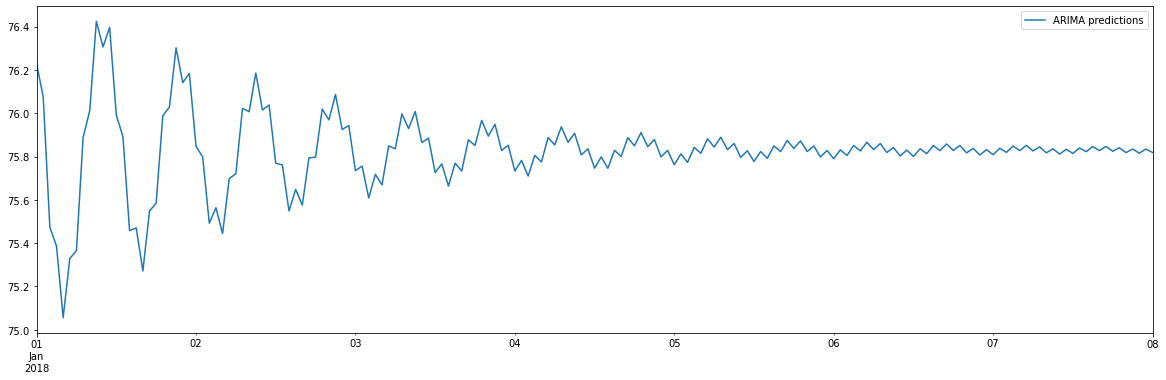

In [28]:
pred.plot(figsize = (20,6), legend = True)

<AxesSubplot:xlabel='timestamp'>

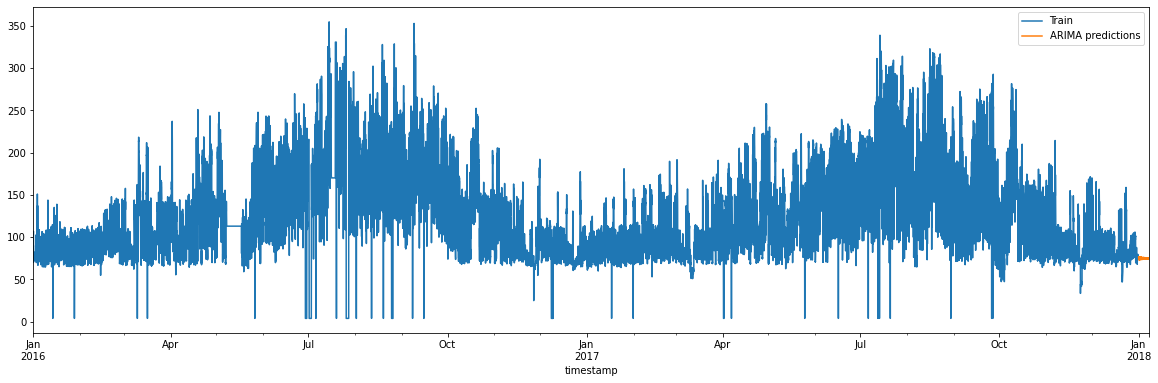

In [19]:
building.plot(figsize = (20,6), label = 'Train',legend = True)

pred.plot(figsize = (20,6), legend = True)

In [20]:
# evaluate forecasts
#rmse = sqrt(mean_squared_error(building, pred))
#print('Test RMSE: %.3f' % rmse)

In [21]:
#test.mean(),np.sqrt(test.var())

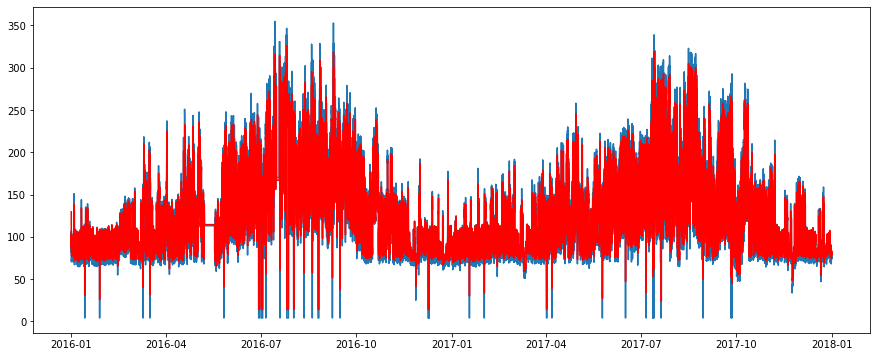

In [22]:

plt.figure(figsize = (15,6))
model = ARIMA (building, order = (1,0,1)) #number of order taken from the graph
results_ARIMA = model.fit ()
plt.plot (building)
plt.plot(results_ARIMA.fittedvalues, color = 'red')

In [23]:
print (results_ARIMA.summary())

                                 SARIMAX Results                                 
Dep. Variable:     Eagle_assembly_Portia   No. Observations:                17544
Model:                    ARIMA(1, 0, 1)   Log Likelihood              -80752.846
Date:                   Mon, 26 Apr 2021   AIC                         161513.693
Time:                           01:02:24   BIC                         161544.782
Sample:                       01-01-2016   HQIC                        161523.929
                            - 12-31-2017                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        129.5251      2.673     48.463      0.000     124.287     134.763
ar.L1          0.9350      0.003    320.707      0.000       0.929       0.941
ma.L1         -0.1963      0

## Taking results back to original scale

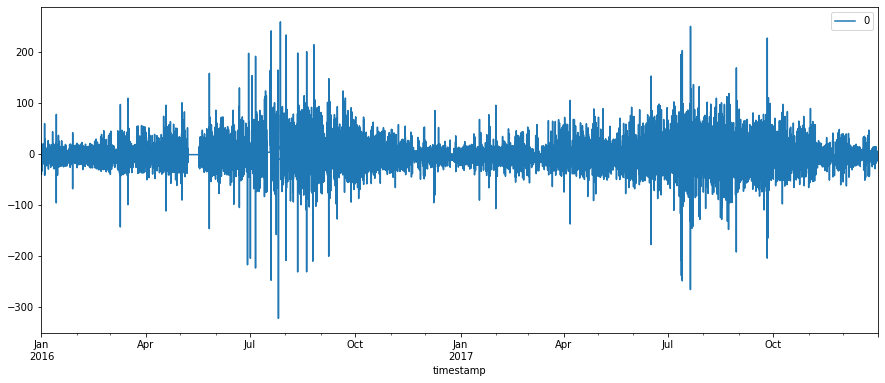

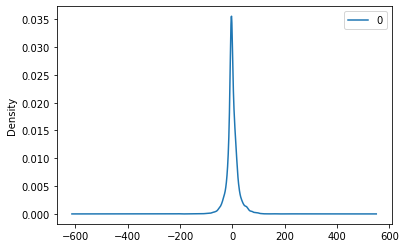

                  0
count  17544.000000
mean      -0.002988
std       24.142633
min     -322.376325
25%       -8.789154
50%       -2.091126
75%        8.671611
max      259.031807


In [24]:
# line plot of residuals
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(figsize = (15,6))
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())